# 数据准备

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置图表风格和参数
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'sans-serif' # 使用通用字体以确保英文正常显示
plt.rcParams['axes.unicode_minus'] = False # 确保负号正常显示

# 加载数据集
try:
    df = pd.read_csv('/home/xyli/ML-final-main/ML-3/data/train_processed.csv')
except FileNotFoundError:
    print("train_processed.csv not found. Please ensure the file is in the correct directory.")
    # 如果文件不存在，可以从用户提供的OCR内容中创建一个临时的DataFrame
    # 此处假设文件存在
    pass

# 数据预处理
# 将 'date' 列转换为 datetime 类型
df['date'] = pd.to_datetime(df['date'])
# 将 'date' 列设置为索引
df.set_index('date', inplace=True)

# 根据文档说明，修正降水单位（原始值为毫米的十分之一）
df['RR'] = df['RR'] / 10

# 打印数据的前几行以确认
print(df.head())

            global_active_power  global_reactive_power  sub_metering_1  \
date                                                                     
2006-12-16             1209.176                 34.922             0.0   
2006-12-17             3390.460                226.006          2033.0   
2006-12-18             2203.826                161.792          1063.0   
2006-12-19             1666.194                150.942           839.0   
2006-12-20             2225.748                160.998             0.0   

            sub_metering_2  sub_metering_3     voltage  global_intensity  \
date                                                                       
2006-12-16           546.0          4926.0  236.243763         13.082828   
2006-12-17          4187.0         13341.0  240.087028          9.999028   
2006-12-18          2621.0         14018.0  241.231694          6.421667   
2006-12-19          7602.0          6197.0  241.999313          4.926389   
2006-12-20          2648.

In [13]:
# 显示数据集的基本信息
print("--- Data Info ---")
df.info()

# 显示数值列的描述性统计
print("\n--- Descriptive Statistics ---")
print(df.describe())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 747 entries, 2006-12-16 to 2008-12-31
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   global_active_power     747 non-null    float64
 1   global_reactive_power   747 non-null    float64
 2   sub_metering_1          747 non-null    float64
 3   sub_metering_2          747 non-null    float64
 4   sub_metering_3          747 non-null    float64
 5   voltage                 747 non-null    float64
 6   global_intensity        747 non-null    float64
 7   RR                      747 non-null    float64
 8   NBJRR1                  747 non-null    float64
 9   NBJRR5                  747 non-null    float64
 10  NBJRR10                 747 non-null    float64
 11  NBJBROU                 747 non-null    float64
 12  sub_metering_remainder  747 non-null    float64
dtypes: float64(13)
memory usage: 81.7 KB

--- Descriptive Stat

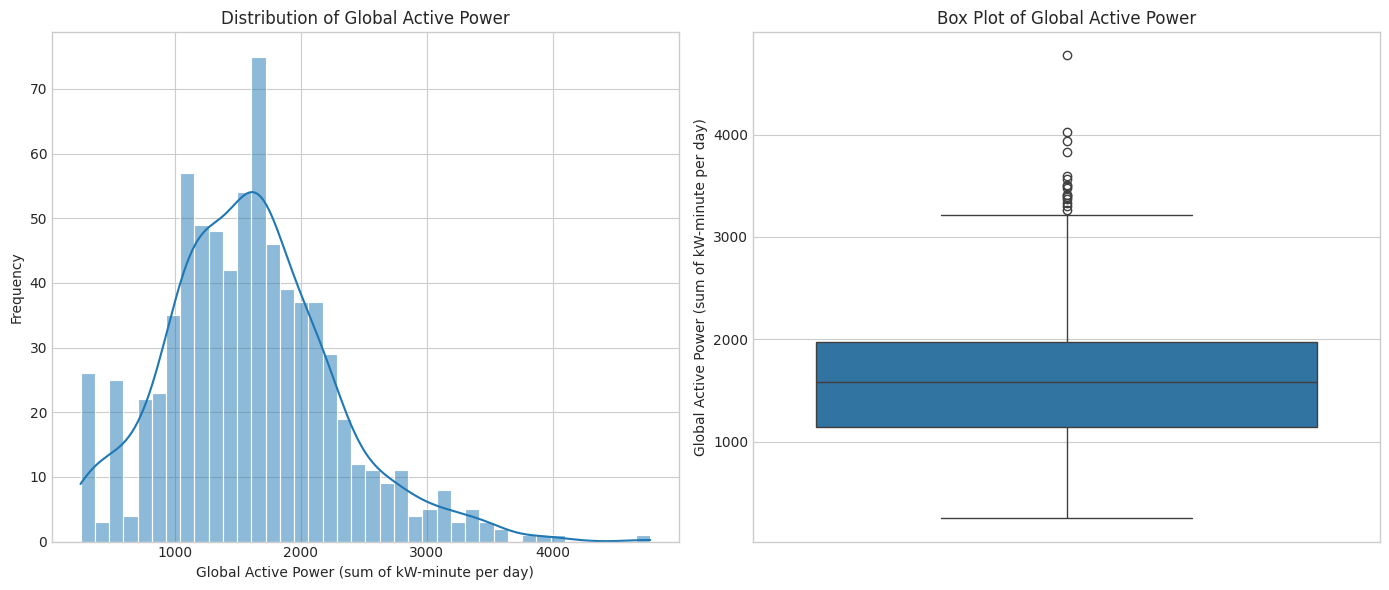

In [14]:
plt.figure(figsize=(14, 6))

# 绘制直方图和核密度估计图
plt.subplot(1, 2, 1)
sns.histplot(df['global_active_power'], kde=True, bins=40)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (sum of kW-minute per day)')
plt.ylabel('Frequency')

# 绘制箱线图
plt.subplot(1, 2, 2)
sns.boxplot(y=df['global_active_power'])
plt.title('Box Plot of Global Active Power')
plt.ylabel('Global Active Power (sum of kW-minute per day)')

plt.tight_layout()
plt.show()

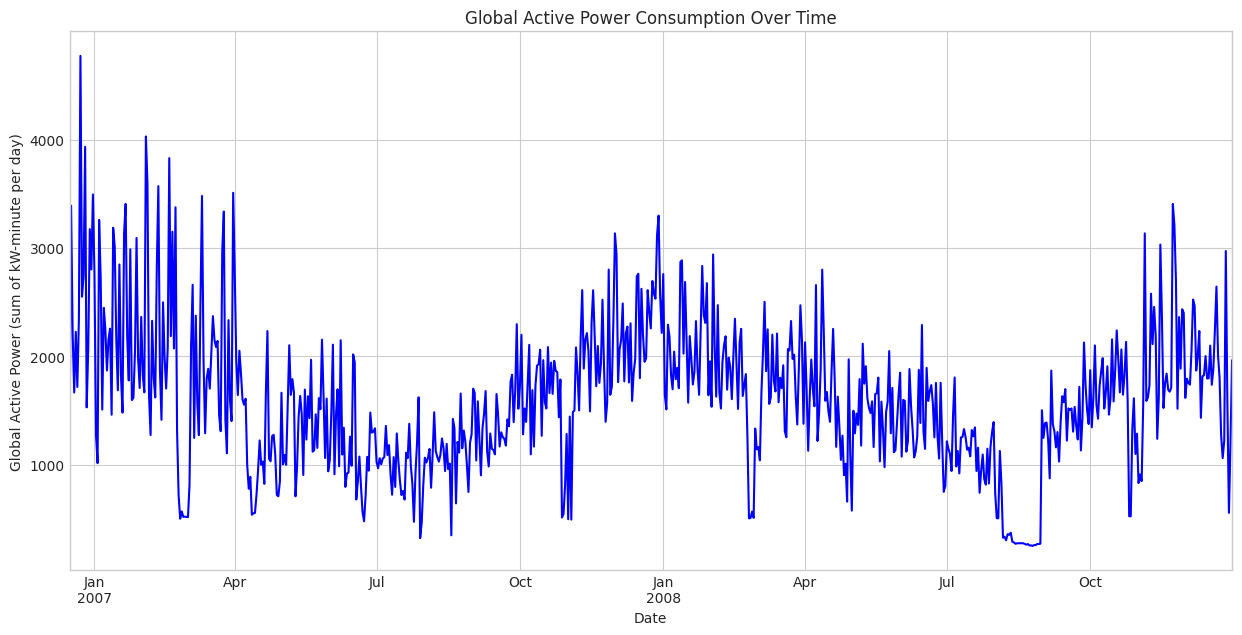

In [15]:
df['global_active_power'].plot(figsize=(15, 7), color='blue')
plt.title('Global Active Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Global Active Power (sum of kW-minute per day)')
plt.show()

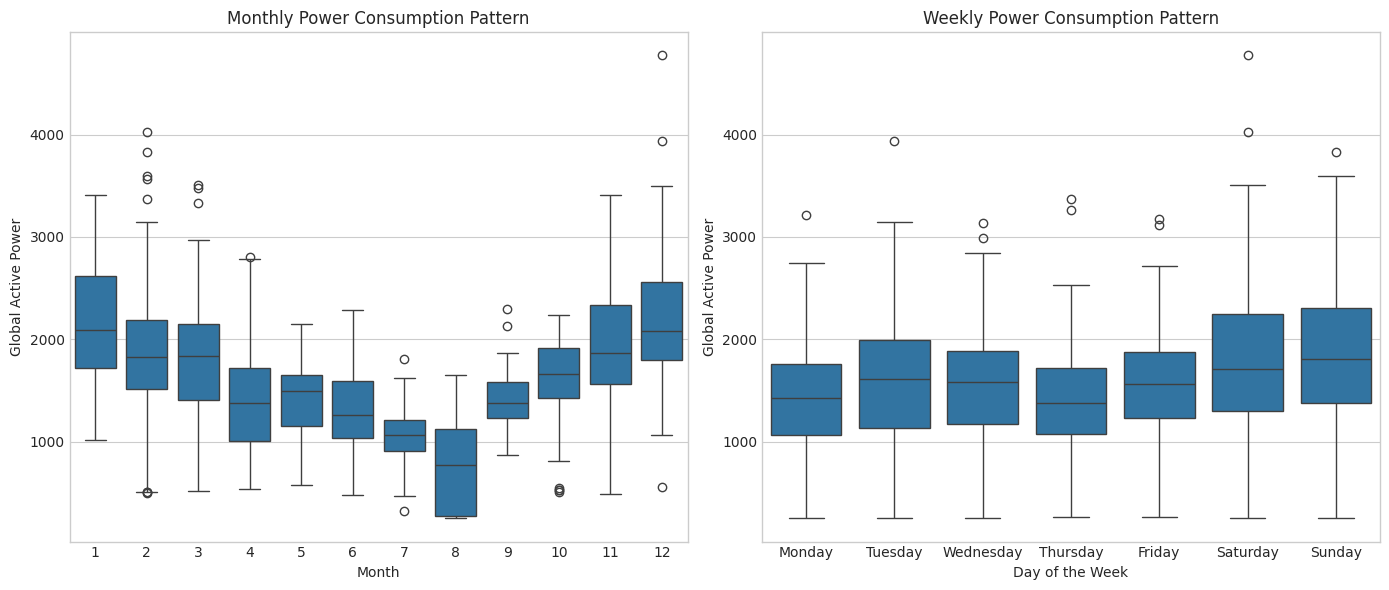

In [16]:
# 创建月份和星期几的列
df['month'] = df.index.month
df['day_of_week'] = df.index.day_name()

plt.figure(figsize=(14, 6))

# 月度用电量箱线图
plt.subplot(1, 2, 1)
sns.boxplot(x='month', y='global_active_power', data=df)
plt.title('Monthly Power Consumption Pattern')
plt.xlabel('Month')
plt.ylabel('Global Active Power')

# 周度用电量箱线图
plt.subplot(1, 2, 2)
# 定义星期的顺序
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='day_of_week', y='global_active_power', data=df, order=weekday_order)
plt.title('Weekly Power Consumption Pattern')
plt.xlabel('Day of the Week')
plt.ylabel('Global Active Power')

plt.tight_layout()
plt.show()

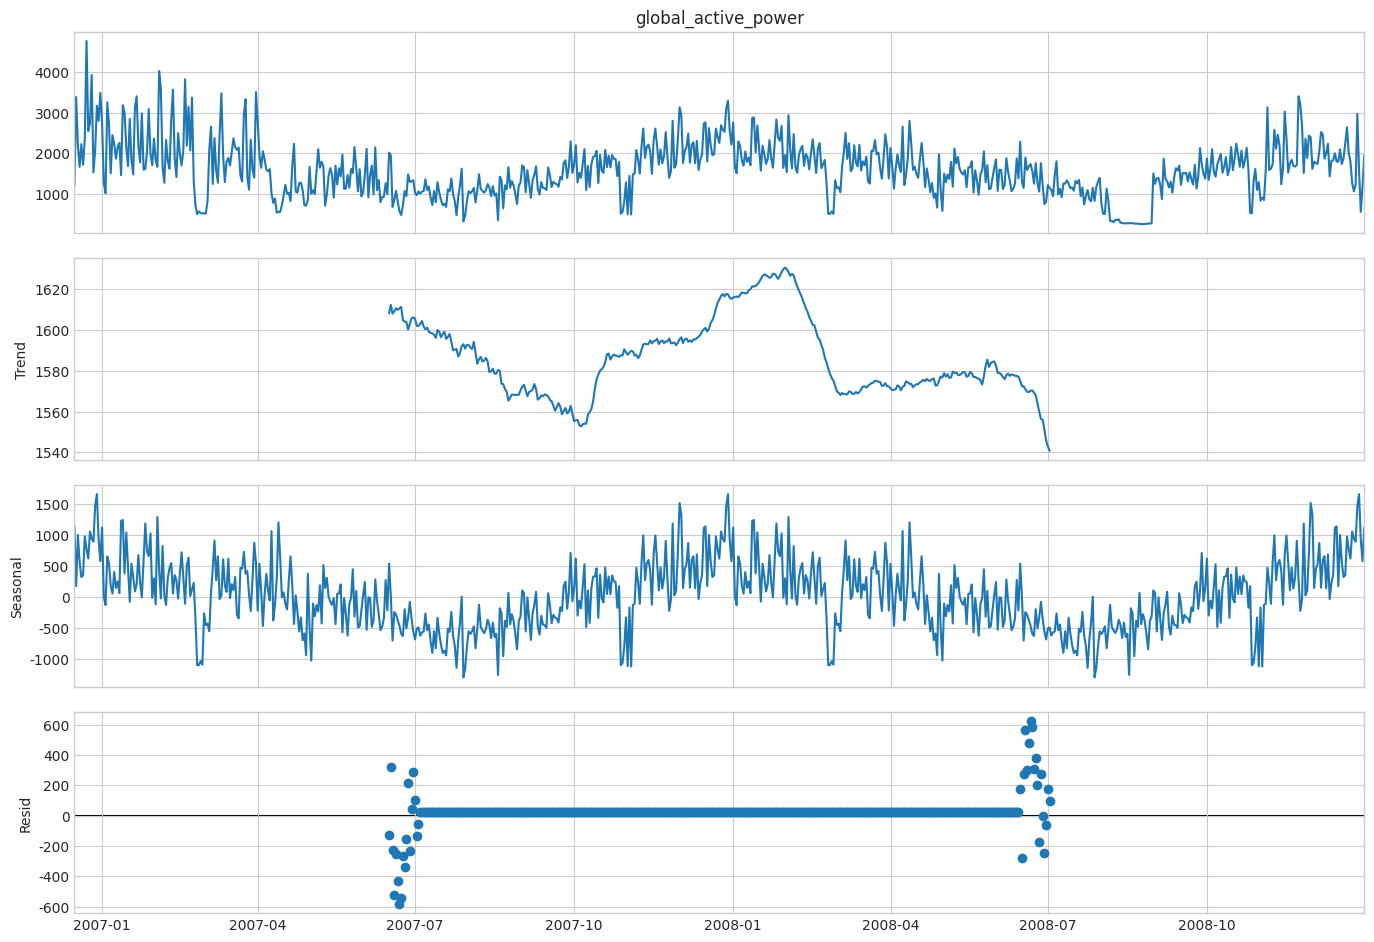

In [18]:
# 使用加法模型进行分解，因为季节性波动幅度看起来相对稳定
decomposition = seasonal_decompose(df['global_active_power'], model='additive', period=365)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
# plt.suptitle('Time Series Decomposition of Global Active Power', y=0.95)
plt.show()

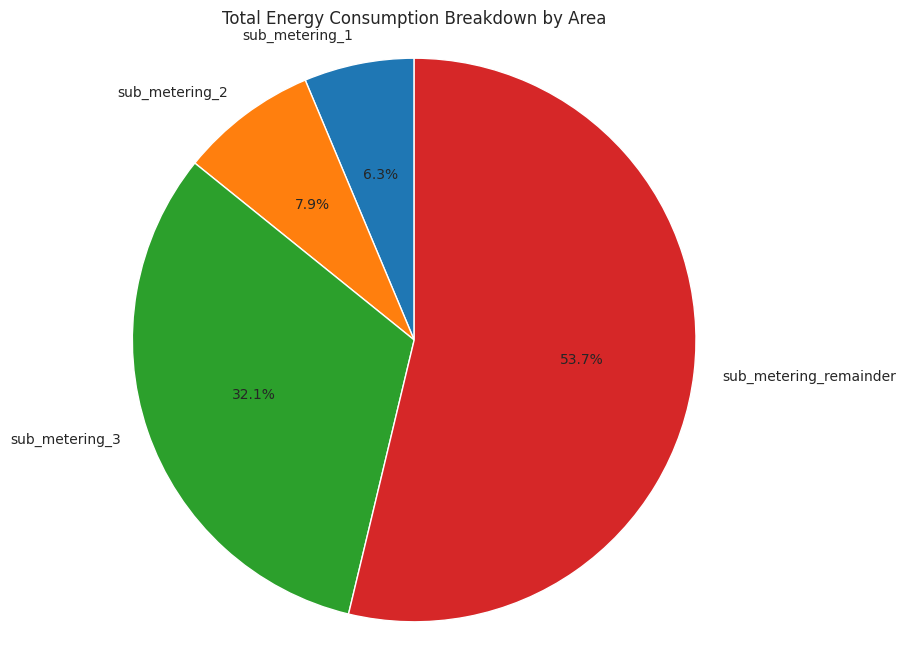

In [36]:
# 计算每个子表的总能耗
# 注意：global_active_power的单位是kW-minute，其他是Wh。需要统一单位。
# (kW-minute) * 1000 / 60 = Wh
total_energy_wh = df['global_active_power'].sum() * 1000 / 60
sub_metering_totals = {
    'sub_metering_1': df['sub_metering_1'].sum(),
    'sub_metering_2': df['sub_metering_2'].sum(),
    'sub_metering_3': df['sub_metering_3'].sum(),
    'sub_metering_remainder': df['sub_metering_remainder'].sum()
}

# 准备饼图数据
labels = sub_metering_totals.keys()
sizes = sub_metering_totals.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        wedgeprops={'edgecolor': 'white'})
plt.title('Total Energy Consumption Breakdown by Area')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

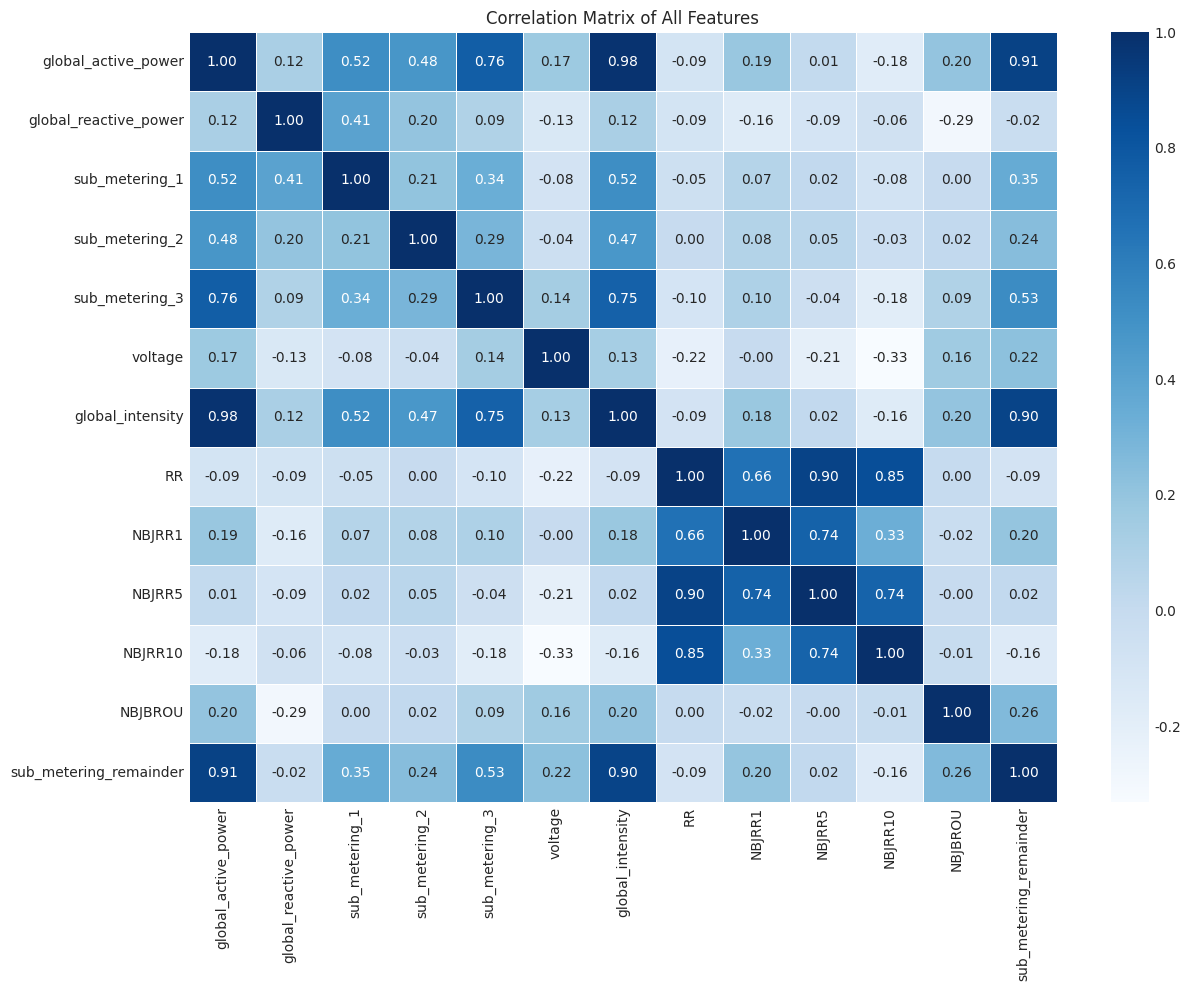

In [26]:
# 计算相关系数矩阵
correlation_matrix = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of All Features')
plt.show()

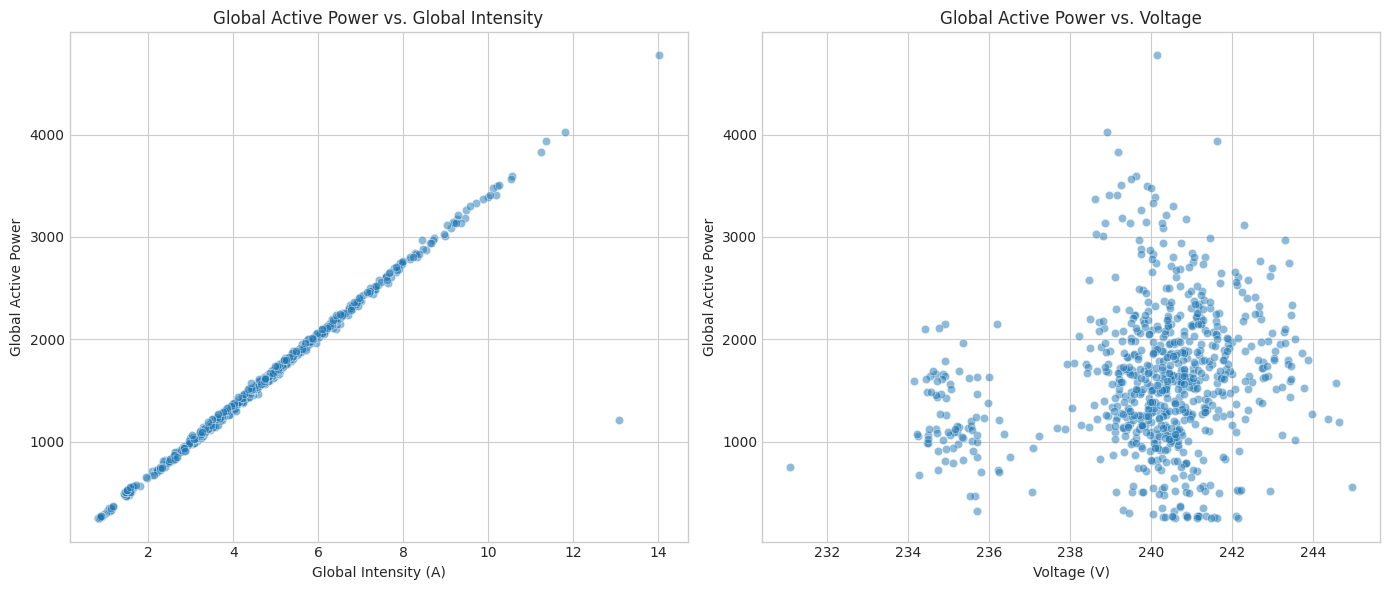

In [27]:
plt.figure(figsize=(14, 6))

# GAP vs Global Intensity
plt.subplot(1, 2, 1)
sns.scatterplot(x='global_intensity', y='global_active_power', data=df, alpha=0.5)
plt.title('Global Active Power vs. Global Intensity')
plt.xlabel('Global Intensity (A)')
plt.ylabel('Global Active Power')

# GAP vs Voltage
plt.subplot(1, 2, 2)
sns.scatterplot(x='voltage', y='global_active_power', data=df, alpha=0.5)
plt.title('Global Active Power vs. Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('Global Active Power')

plt.tight_layout()
plt.show()

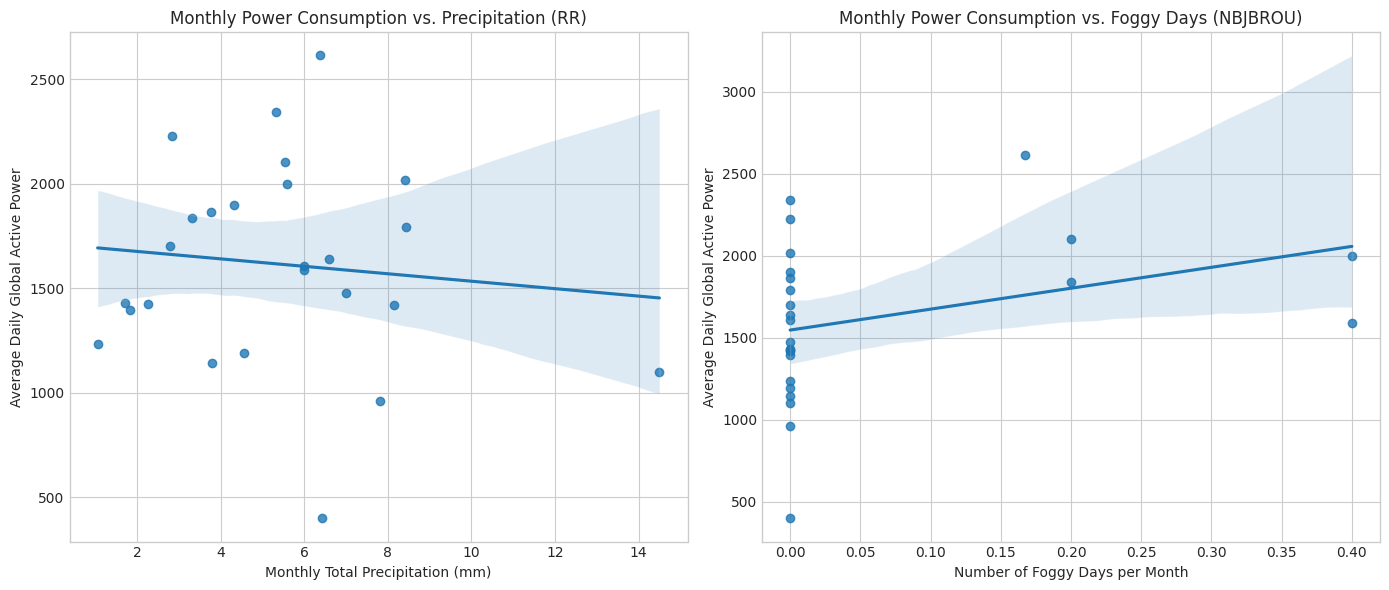

In [28]:
# 按月重采样数据，计算月平均值
df_monthly = df.resample('M').mean()

plt.figure(figsize=(14, 6))

# 月均用电量 vs 月总降水量
plt.subplot(1, 2, 1)
sns.regplot(x='RR', y='global_active_power', data=df_monthly)
plt.title('Monthly Power Consumption vs. Precipitation (RR)')
plt.xlabel('Monthly Total Precipitation (mm)')
plt.ylabel('Average Daily Global Active Power')

# 月均用电量 vs 月雾天数
plt.subplot(1, 2, 2)
sns.regplot(x='NBJBROU', y='global_active_power', data=df_monthly)
plt.title('Monthly Power Consumption vs. Foggy Days (NBJBROU)')
plt.xlabel('Number of Foggy Days per Month')
plt.ylabel('Average Daily Global Active Power')

plt.tight_layout()
plt.show()

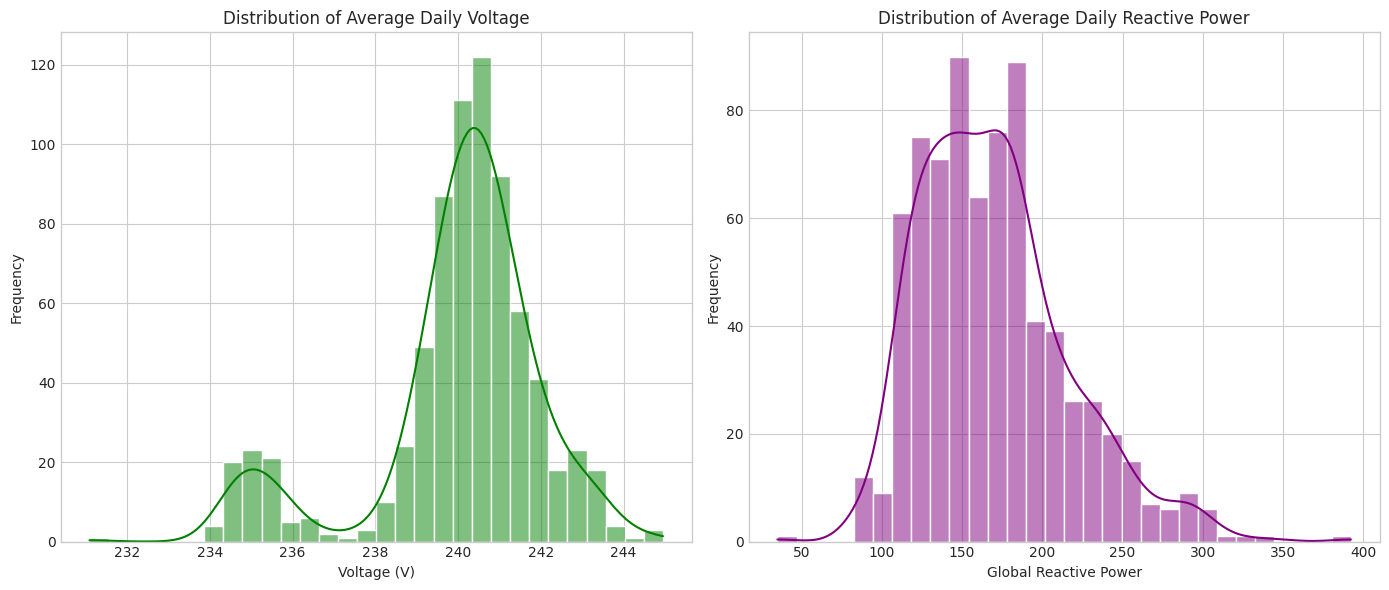

In [29]:
plt.figure(figsize=(14, 6))

# 电压分布
plt.subplot(1, 2, 1)
sns.histplot(df['voltage'], kde=True, bins=30, color='green')
plt.title('Distribution of Average Daily Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency')

# 无功功率分布
plt.subplot(1, 2, 2)
sns.histplot(df['global_reactive_power'], kde=True, bins=30, color='purple')
plt.title('Distribution of Average Daily Reactive Power')
plt.xlabel('Global Reactive Power')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

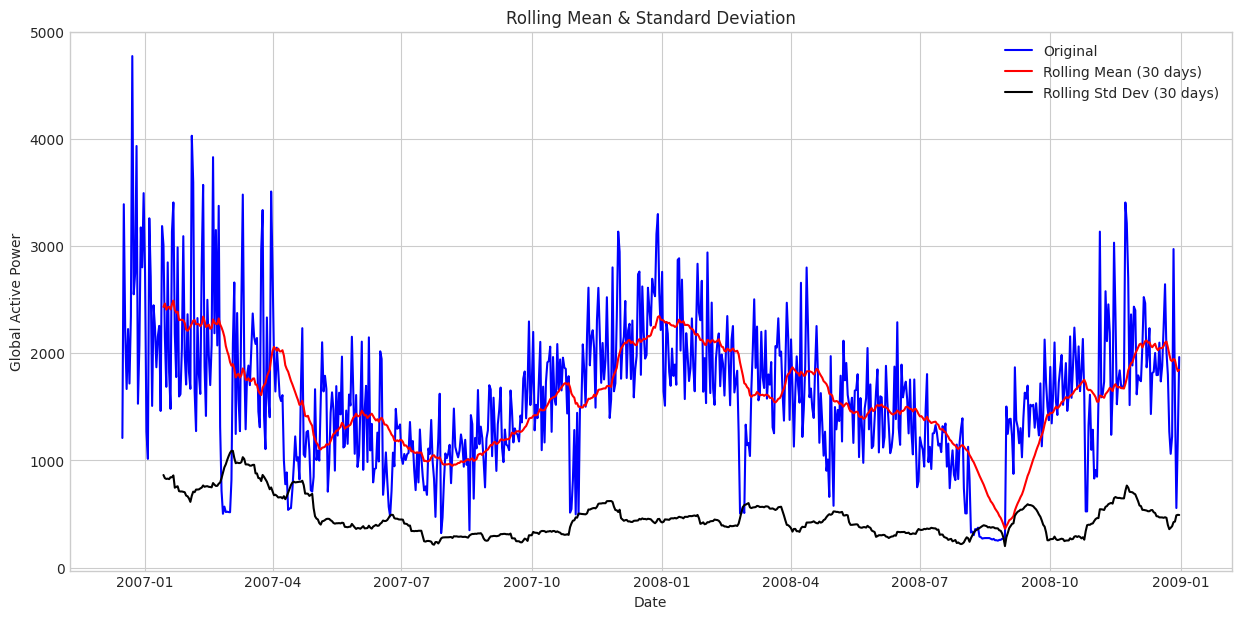

In [30]:
# 计算30天的滚动均值和标准差
rolling_mean_30d = df['global_active_power'].rolling(window=30).mean()
rolling_std_30d = df['global_active_power'].rolling(window=30).std()

plt.figure(figsize=(15, 7))
plt.plot(df['global_active_power'], color='blue', label='Original')
plt.plot(rolling_mean_30d, color='red', label='Rolling Mean (30 days)')
plt.plot(rolling_std_30d, color='black', label='Rolling Std Dev (30 days)')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()

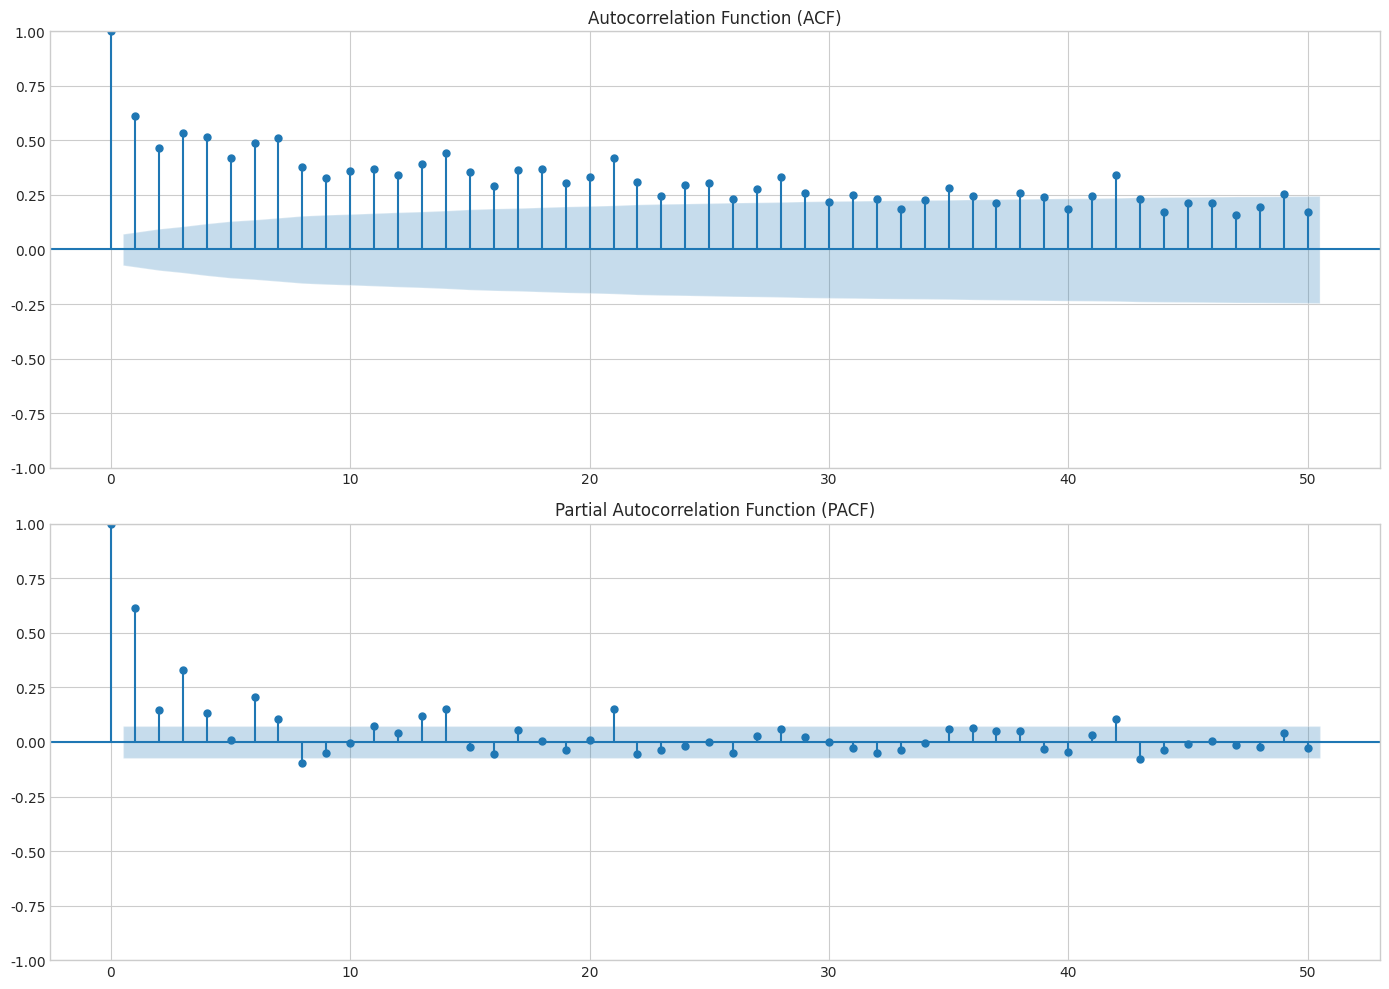

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 绘制ACF图
plot_acf(df['global_active_power'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# 绘制PACF图
plot_pacf(df['global_active_power'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

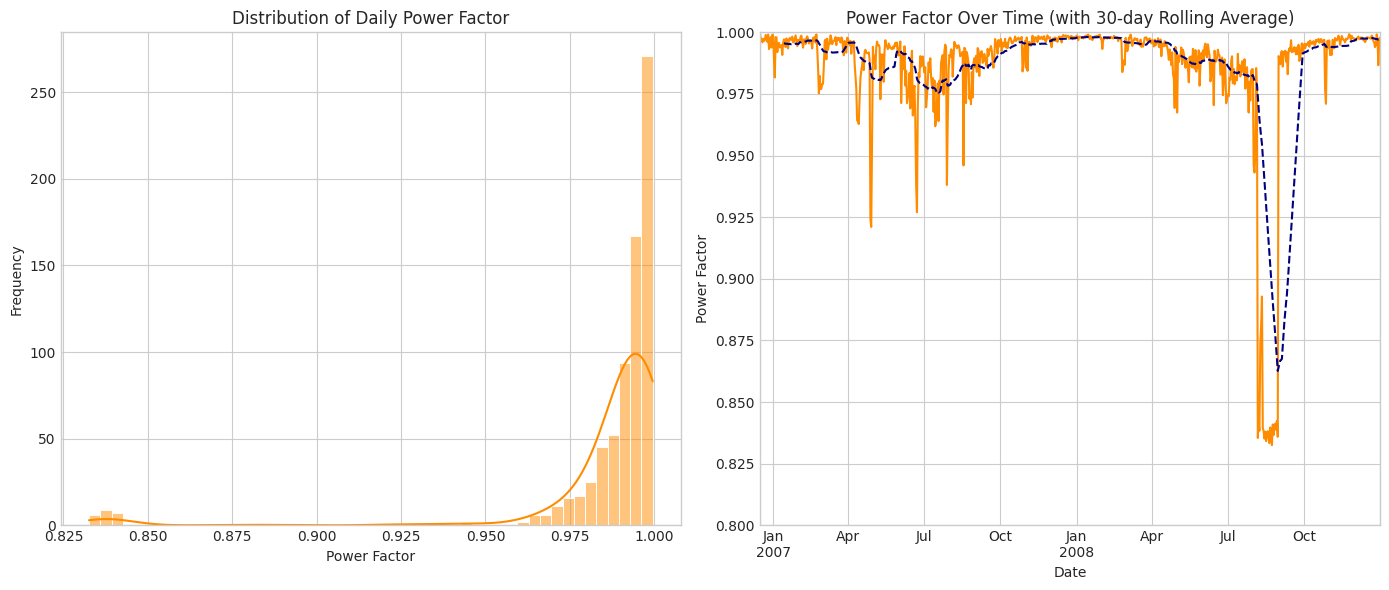

In [32]:
# 计算视在功率 (Apparent Power)
# 单位均为 kW-minute 的日总和，可以直接计算
df['apparent_power'] = np.sqrt(df['global_active_power']**2 + df['global_reactive_power']**2)

# 计算功率因数 (Power Factor)
# 为避免除以零，在视在功率为0时，将功率因数设为0或NaN（这里设为0）
df['power_factor'] = df.apply(
    lambda row: row['global_active_power'] / row['apparent_power'] if row['apparent_power'] > 0 else 0,
    axis=1
)

plt.figure(figsize=(14, 6))

# 绘制功率因数的分布图
plt.subplot(1, 2, 1)
sns.histplot(df['power_factor'], bins=50, kde=True, color='darkorange')
plt.title('Distribution of Daily Power Factor')
plt.xlabel('Power Factor')
plt.ylabel('Frequency')

# 绘制功率因数的时间序列图
plt.subplot(1, 2, 2)
df['power_factor'].plot(color='darkorange')
# 计算30天滚动平均值以平滑曲线
df['power_factor'].rolling(window=30).mean().plot(color='navy', linestyle='--')
plt.title('Power Factor Over Time (with 30-day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.ylim(0.8, 1.0) # 放大显示主要变化范围

plt.tight_layout()
plt.show()

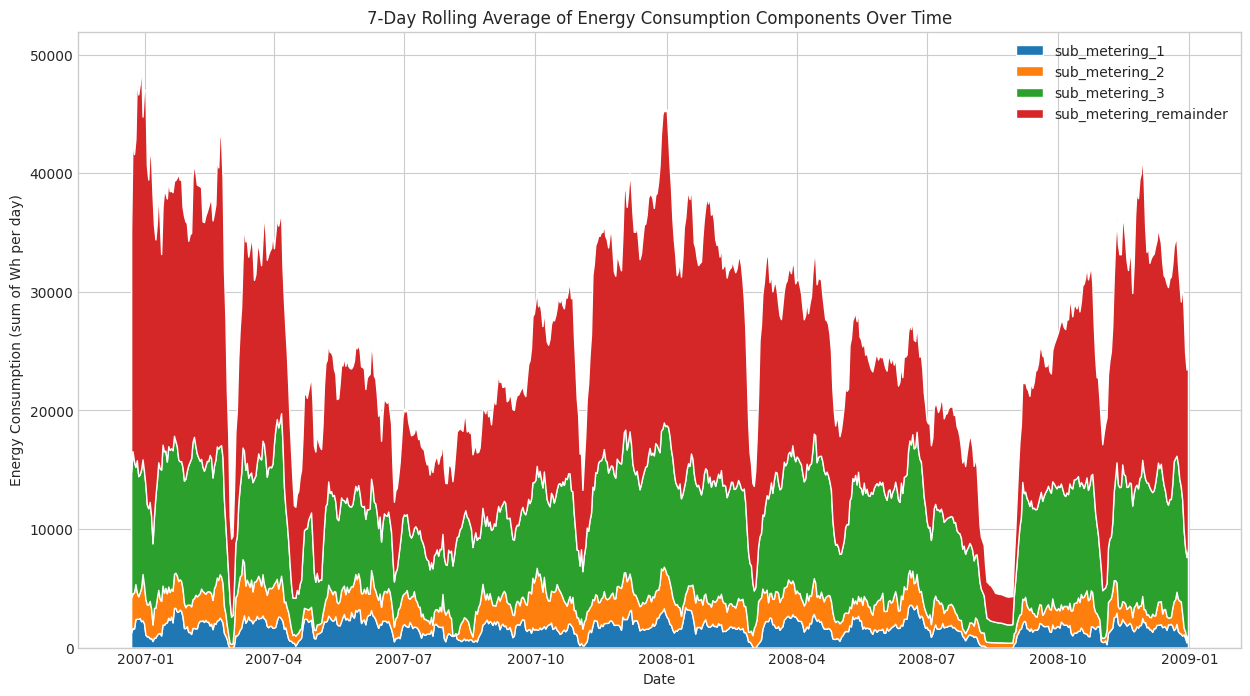

In [35]:
# 为了使图像更清晰，我们对数据进行7天滚动平均
df_rolling_7d = df[['sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'sub_metering_remainder']].rolling(window=7).mean()

# 绘图
plt.figure(figsize=(15, 8))
plt.stackplot(df_rolling_7d.index, 
              df_rolling_7d['sub_metering_1'], 
              df_rolling_7d['sub_metering_2'], 
              df_rolling_7d['sub_metering_3'],
              df_rolling_7d['sub_metering_remainder'],
              labels=['sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'sub_metering_remainder'])

plt.legend(loc='upper right')
plt.title('7-Day Rolling Average of Energy Consumption Components Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (sum of Wh per day)')
plt.show()

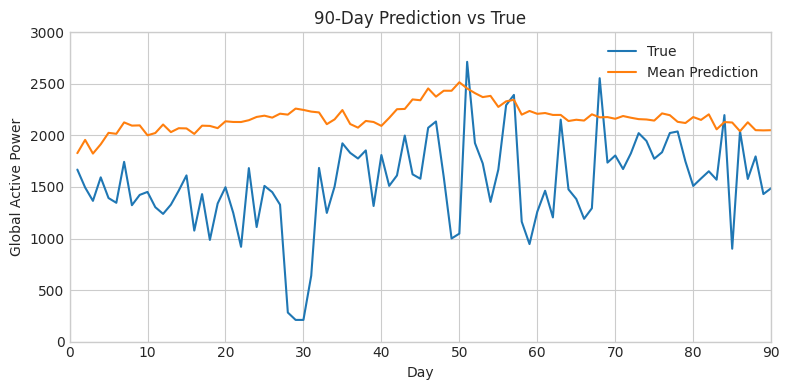

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取 5 个 run 文件
files = [f'/home/xyli/ML-final-main/individual_results_short_run{i}.csv' for i in range(1, 6)]
dfs   = [pd.read_csv(f) for f in files]

# 2. 把 5 份预测值取平均
pred_mean = np.mean([df['Predicted_Global_active_power'].values for df in dfs], axis=0)
true_vals = dfs[0]['True_Global_active_power'].values          # 5 份真实值相同，取一份即可
days      = np.arange(1, len(true_vals)+1)                     # 1,2,...,89

# 3. 画图
plt.figure(figsize=(8,4))
plt.plot(days, true_vals,  label='True', color='#1f77b4')
plt.plot(days, pred_mean,  label='Mean Prediction', color='#ff7f0e')
plt.title('90-Day Prediction vs True')
plt.xlabel('Day')
plt.ylabel('Global Active Power')
plt.xlim(0, 90)
plt.ylim(0, 3000)
plt.legend()
plt.tight_layout()
plt.show()

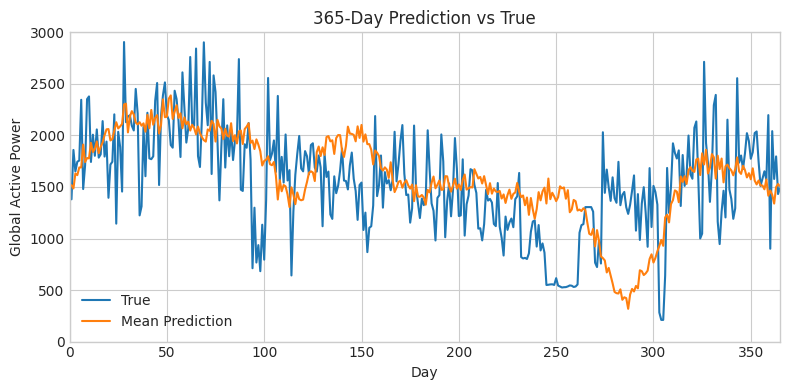

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取 5 个 run 文件
files = [f'/home/xyli/ML-final-main/individual_results_long_run{i}.csv' for i in range(1, 6)]
dfs   = [pd.read_csv(f) for f in files]

# 2. 把 5 份预测值取平均
pred_mean = np.mean([df['Predicted_Global_active_power'].values for df in dfs], axis=0)
true_vals = dfs[0]['True_Global_active_power'].values          # 5 份真实值相同，取一份即可
days      = np.arange(1, len(true_vals)+1)                     # 1,2,...,89

# 3. 画图
plt.figure(figsize=(8,4))
plt.plot(days, true_vals,  label='True', color='#1f77b4')
plt.plot(days, pred_mean,  label='Mean Prediction', color='#ff7f0e')
plt.title('365-Day Prediction vs True')
plt.xlabel('Day')
plt.ylabel('Global Active Power')
plt.xlim(0, 365)
plt.ylim(0, 3000)
plt.legend()
plt.tight_layout()
plt.show()